Based on [_1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50) and [_2](https://www.kaggle.com/abhiksark/introduction-to-transfer-learning-cats-dogs)
# Transfer learning
It is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, cv2, random
from tqdm import tqdm
from random import shuffle
from zipfile import ZipFile
import glob

%matplotlib inline

In [2]:
zip_file = glob.glob('../input/dogs-vs-cats-redux-kernels-edition/*.zip')  #return any files with .zip extension
print(zip_file)

#extract file into a temp folder
def extract_zip(file):
    with ZipFile(file,'r') as zip_ref:
        zip_ref.extractall('.')
        
#extract both train and test1 zip
for files in zip_file:
    extract_zip(files)

['../input/dogs-vs-cats-redux-kernels-edition/test.zip', '../input/dogs-vs-cats-redux-kernels-edition/train.zip']


In [3]:
# Global Constants
TRAIN_DIR = '../working/train'
TEST_DIR = '../working/test'
NUM_CLASSES = 2
IMG_SIZE = 224
EPOCHS = 20

train_images = os.listdir(TRAIN_DIR)#[:10000] # For testing purposes
test_images = os.listdir(TEST_DIR)

In [4]:
# Return one-hot array [cat, dog] of image
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog' : return [0, 1]

# Return a numpy array of train and test data
def create_train_data():
    training_data = []
    for img in tqdm(train_images):
        label = label_img(img)
        img_path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(test_images):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    shuffle(testing_data)
    return testing_data

training_data = create_train_data()
X = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in training_data])

100%|██████████| 25000/25000 [00:59<00:00, 420.84it/s]


In [5]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense

# Path of ResNet50 pre-trained weights except its TOP layer,
RESNET_WEIGHTS_PATH = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()
model.add(ResNet50(include_top = False,
                   pooling = 'max',
                   weights = RESNET_WEIGHTS_PATH))
model.add(Dense(NUM_CLASSES, activation= 'softmax'))
model.layers[0].trainable = False

# Compile the Transfer Learning Model
sgd = optimizers.SGD(lr = 1e-3, decay = 1e-6, momentum = 0.1, nesterov=True)
model.compile(optimizer= sgd, loss = 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


## Training

In [6]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
check_point = ModelCheckpoint('BestModel.hdf5', verbose=True, save_best_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=3, verbose=1)
history = model.fit(X, y,
                    validation_split=0.2,
                    callbacks = [check_point, lr_reduce],
                    epochs=EPOCHS,
                    batch_size=80,
                    verbose=1)

# Plotting loss and accuracy for the model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 78s 4ms/step - loss: 0.3818 - acc: 0.9395 - val_loss: 0.2166 - val_acc: 0.9668

Epoch 00001: val_loss improved from inf to 0.21663, saving model to BestModel.hdf5
Epoch 2/20
20000/20000 [==============================] - 71s 4ms/step - loss: 0.1508 - acc: 0.9708 - val_loss: 0.1550 - val_acc: 0.9732

Epoch 00002: val_loss improved from 0.21663 to 0.15502, saving model to BestModel.hdf5
Epoch 3/20
20000/20000 [==============================] - 70s 3ms/step - loss: 0.1078 - acc: 0.9776 - val_loss: 0.1592 - val_acc: 0.9742

Epoch 00003: val_loss did not improve from 0.15502
Epoch 4/20
20000/20000 [==============================] - 70s 3ms/step - loss: 0.0939 - acc: 0.9808 - val_loss: 0.1848 - val_acc: 0.9712

Epoch 00004: val_loss did not improve from 0.15502
Epoch 5/20
20000/20000 [==============================] - 70s 3ms/step - loss: 0.0934 - acc: 0.9804 - val_loss: 0.2940 - val_ac

## Testing

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/engine/saving.py:328: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
100%|██████████| 12500/12500 [00:26<00:00, 464.35it/s]


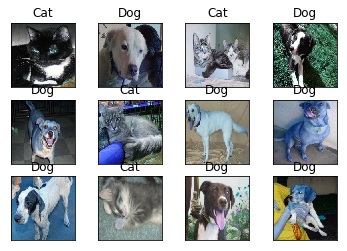

In [7]:
# Free some space
import gc
del X, y, training_data
gc.collect()

# Load Best model
from keras.models import load_model
model = load_model('BestModel.hdf5')

# Testing Model on Test Data
test_data = process_test_data()
fig =plt.figure()
for num, data in enumerate(test_data[:12]):
    # Cat: [1, 0]
    # Dog: [0, 1]
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    data = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1 : str_label ='Dog'
    else: str_label = 'Cat'
    y.imshow(img_data)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False);
    y.axes.get_yaxis().set_visible(False);
plt.show()